In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob, numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
sn.set_context('notebook')

# Hydrological indicators revisited

In this notebook I'd like to calculate a new set of hydrological parameters. Previous work has demonstrated the following:

* The IHA package in R only works with either whole water years (October to October) or whole calendar years (January to January). Anything else, such as using one year of data prior to sampling, gives strange results. <br><br>

* Several of the IHA parameters don't seem to be related to our ecological data (see e.g. [this notebook](http://nbviewer.jupyter.org/url/www.googledrive.com/host/0BximeC_RweaeVkYteXFqNE1XWXc/ecoreg_prelim_analysis.ipynb)). We can therefore probably get away with calculating a reduced set. <br><br>

* Using the sampling times selected by Jannicke and Susi, most of the sites have 5 years' worth of flow data prior to sampling, **but some of the German sites only have 3**. 

The aim of this notebook is to:

 1. Produce simplified Python code for a subset of the IHA parameters that can be calculated using data for any time period. I don't intend to recode the whole IHA methodlogy at this stage - just the parameters that seem most relevant based on the work to date. Susi's draft paper based on the Norwegian dataset also provides some useful guidance. If these indicators don't work, I can always come back and refine them later. <br><br>
 
 2. Calculate new hydrological metrics based on **1 and 3 years of data prior to sampling**. This is a bit less than the 5 years I've worked with so far, but it ensures the indicators are based on real data, rather than interpolated values.
 
## 1. Choose indicators

To begin with, I'll calculate the following 62 quantities:

 * Overall mean discharge (1 parameter). The mean daily flow over then entire flow record. <br><br>
 
 * Monthly minimum, mean and maximum discharge (36 parameters). The minimum, mean and maximum of all daily flow values in each month over the period of interest. <br><br>
 
 * Min, P05, P25, P50, P75, P95, max, range, IQR and 90 percentile range (10 parameters). The range is calculated as $(maximum - minimum)$, the IQR as $(P75 - P25)$ and the 90 percentile range as $(P95 - P05)$. <br><br>
 
 * [Coefficient of variation (CV)](https://en.wikipedia.org/wiki/Coefficient_of_variation) of flows (1 parameter).
 
 $$CV = \frac{\sigma}{\bar x}$$
 
 where $\sigma$ is the standard deviation and $\bar x$ is the mean. <br><br>
 
 * Days between flow extremes and the sampling date (4 parameters). The number of days from the sampling date to the minimum and maximum flows in the record. Also, the numbers of days to the last point in the record where flows either exceeded the P95 value or fell below the P05 value. <br><br>
 
 * Moving averages (6 parameters). The minimum and maximum of 7-, 30- and 90-day centred moving averages over the period of interest. <br><br>
 
 * Average number of reversals per year (1 parameter). The number of times the flow record switches from rising to falling or vice-versa, divided by the length of the period of interest (in years).  <br><br>
 
 * Number of high pulses (1 parameter) per year. The average number of "events" each year where the flow is greater than P90. <br><br>
 
 * The average daily rise and fall rate (2 parameters). The average rate of change ($m^3/s/day$) from all periods when flows are increasing and all periods when flows are decreasing. (Periods where flows are constant are not included).
 
## 2. Indicators code

I want to develop a function that takes as inputs a full time series (the maximum amount of data available), a sampling date and a time period of interest (an integer number of years). The metrics listed above should then be calculated using a truncated dataset for the time period specified. The function should return a dataframe of the required metrics.

In [2]:
def hydro_indicators(df, samp_date, n_yrs=3, fillna=7):
    """ Calculates a variety of hydrologic parameters from 
        a flow time series.
    
    Args:
        df:        A dataframe with daily resolution containing
                   flow data for the site of interest in "real"
                   units (e.g. m3/s or cfs). Must be a single 
                   column with a date-time index.
        samp_date: String with format 'yyyy-mm-dd'. The sampling 
                   date defining the end of the period of interest
                   Metrics will be calculated for a specified 
                   number of years before this date.                   
        n_yrs:     An integer number of years defining the period 
                   of interest.
        fillna:    No Data gaps will be filled by linear 
                   interpolation. Specify the maximum length of 
                   gaps to fill (numbers of steps).
    
    Returns:
        A dataframe of hydrological metrics.
    """
    import datetime as dt
    from dateutil.relativedelta import relativedelta
    
    # Check input
    assert len(df.columns) == 1, 'The dataframe must have just a single column.'
    assert isinstance(n_yrs, int), 'n_years must be an integer.'
    assert isinstance(fillna, int), 'fillna must be an integer.'

    # Check and parse date
    end_dt = dt.datetime.strptime(samp_date, '%Y-%m-%d')
    st_dt = end_dt - relativedelta(years=n_yrs)
    
    # Get site name
    name = df.columns[0]
                 
    # Truncate
    df = df.truncate(before=st_dt, after=end_dt)
    
    # Ensure no gaps in index
    df = df.reindex(pd.date_range(st_dt, end_dt, freq='D'))

    # Interpolate
    df.interpolate(method='linear', inplace=True, limit=fillna)
    
    # Check no missing data
    if df.isnull().values.any():
        raise ValueError('The series has missing values. Consider increasing the fillna value '
                         'or doing some more pre-processing.')
   
    # Hydrological stats
    # Group 1: Monthly summaries
    # Group 1a: mins for each month
    grp1a_df = df.groupby(df.index.month).min().T
    grp1a_df.columns = ['min%02d' % mon for mon in grp1a_df.columns]
    
    # Group 1b: means for each month
    grp1b_df = df.groupby(df.index.month).mean().T
    grp1b_df.columns = ['avg%02d' % mon for mon in grp1b_df.columns]

    # Group 1c: maxes for each month
    grp1c_df = df.groupby(df.index.month).max().T
    grp1c_df.columns = ['max%02d' % mon for mon in grp1c_df.columns]
    
    # Group 2: percentiles and mean
    grp2_df = df.describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95]).T
    grp2_df = grp2_df[['mean', 'min', '5%', '25%', '50%', '75%', '95%', 'max']]
    grp2_df.columns = ['mean', 'min', 'p05', 'p25', 'p50', 'p75', 'p95', 'max']
    grp2_df['range'] = grp2_df['max'] - grp2_df['min']
    grp2_df['iqr'] = grp2_df['p75'] - grp2_df['p25']
    grp2_df['range90'] = grp2_df['p95'] - grp2_df['p05']    

    # Group 3: CV
    grp3_df = df.describe().T[['std']]/df.mean()[0]
    grp3_df.columns = ['cv',]
    
    # Group 4: Timing of extremes
    # Min and max
    days_to_max = (end_dt - df.idxmax()[0]).days
    days_to_min = (end_dt - df.idxmin()[0]).days
    
    # >= P95
    p95 = grp2_df['p95'][0]
    gt_p95 = (df >= p95).drop_duplicates(keep='last')
    days_to_p95 = (end_dt - gt_p95[gt_p95[name]].index[0]).days
    
    # <= P05
    p05 = grp2_df['p05'][0]
    lt_p05 = (df <= p05).drop_duplicates(keep='last')
    days_to_p05 = (end_dt - lt_p05[lt_p05[name]].index[0]).days
    
    grp4_dict = {'days_to_min':days_to_min,
                 'days_to_max':days_to_max,
                 'days_to_p05':days_to_p05,
                 'days_to_p95':days_to_p95}
    grp4_df = pd.DataFrame(grp4_dict, index=[name,])
    
    # Group 5: Moving averages
    grp5_dict = {}
    
    # Loop over window lengths
    for win in [7, 30, 90]:
        # Loop over statistics
        for stat in ['min', 'max']:
            # Apply window, resample, get stat
            if stat == 'min':
                grp5_dict['ma_%02d_%s' % (win, stat)] = df.rolling(window=win, center=True).mean().min()[0]
            else:
                grp5_dict['ma_%02d_%s' % (win, stat)] = df.rolling(window=win).mean().max()[0]

    grp5_df = pd.DataFrame(grp5_dict, index=[name,])
    
    # Group 6: reversals    
    # Calc diffs, then get sign of diffs, then diffs again. This gives 0 when increasing
    # or decreasing, and +/-2 at changes in direction. Takes abs of this, then sum and
    # divide by 2 to get numbers of reversals
    data = df[name].values
    revs = np.nansum(np.abs(np.diff(np.sign(np.diff(data))))/2.)
    revs_per_yr = revs / n_yrs
    
    grp6_df = pd.DataFrame({'revs_per_yr':revs_per_yr}, index=[name,])

    # Group 7: Number of high pulses
    grp7_df = df.describe(percentiles=[0.90, ]).T   
    p90 = grp7_df['90%'][0]
    grp7_df = (df > p90).astype(int)
    
    # First differences give +1 at start and -1 at end of each pulse. abs()
    # gives +1 at start and end. Sum and / 2 to get total number of pulses
    n_pulse = grp7_df.diff().abs().sum() / (2. * n_yrs)
    
    grp7_df = pd.DataFrame({'n_hi_pulse_yr':n_pulse}, index=[name,])
    
    # Group 8: Average rise and fall rate
    grp8_df = df.diff()
    grp8_df['sign'] = np.sign(grp8_df[name])
    grpd = grp8_df.groupby('sign')
    grp8_df = grpd.agg('mean')

    fall_rate =  grp8_df.ix[-1, name]
    rise_rate =  grp8_df.ix[1, name]

    grp8_dict = {'av_fall_rt':fall_rate,
                 'av_rise_rt':rise_rate}
    grp8_df = pd.DataFrame(grp8_dict, index=[name,])
    
    # Concatenate
    dfs = [grp1a_df, grp1b_df, grp1c_df, grp2_df, grp3_df, grp4_df, grp5_df, 
           grp6_df, grp7_df, grp8_df]
    hi_df = pd.concat(dfs, axis=1)
    
    return hi_df

## 3. Calculate indicators

### 3.2. Get german sites and sampling times of interest

In [3]:
# Get sampling/survey times for German sites

# File paths
ger_sites_xls = (r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany\Susi_Selected_German_Sites.xlsx')

ger_id_xls = (r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany\sites_and_ecol.xlsx')

# Read data
ger_sites = pd.read_excel(ger_sites_xls, sheetname='summary sites')
ger_ids = pd.read_excel(ger_id_xls, sheetname='overview')

# Join
ger_sites = pd.merge(ger_sites, ger_ids, how='left', left_on='ID_RS', right_on='ID_RS')

# Get columns of interest and rename
ger_sites = ger_sites[['ID_RS', 'Site', 'date PB', 'date MZB', 'suitable for MZB analyses']]
ger_sites.columns = ['site', 'name', 'pb', 'mzb', 'use_mzb']

ger_sites.head()

,site,name,pb,mzb,use_mzb
0,107000582,altenburg,2009-09-13 15:00:00,2009-06-02,x
1,107000628,gemuend,2009-09-14 15:00:00,2009-05-04,x
2,107000671,kornelimuenster,2007-10-21 15:00:00,2007-05-31,x
3,107001160,oberagger,2009-08-20 15:00:00,2009-04-07,x
4,107001168,rebbelroth,2006-07-26 15:00:00,2006-07-14,x


### 3.2. Read German flows data

In [4]:
# Read German flows data
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Raw_Data\germany_daily_flows.xlsx'
ger_df = pd.read_excel(in_xls, sheetname='germany_daily_flows', index_col=0)

ger_df.head()

,altenburg,beddelhausen,bredelar,broel,bueren,geisbach,gemuend,hagen-haspe,herrntrop,kornelimuenster,...,oberagger,opladen,rebbelroth,rueblinghausen,stephansohl,walkmuehle,weidenau,weidenau2,weine,welda
date,,,,,,,,,,,,,,,,,,,,,
2002-11-01,26.871875,18.268708,1.877594,3.672760,0.969760,0.415208,4.621177,2.431885,1.921260,0.415573,...,0.290875,18.727771,1.718737,2.086000,1.908448,0.494516,3.243656,3.235000,1.692729,3.491375
2002-11-02,23.022760,16.494115,2.390760,9.018885,1.489625,2.006896,11.703563,6.462063,2.376573,0.934281,...,0.891073,31.387135,6.230521,5.112292,4.790135,0.496000,5.062771,7.806500,2.939740,4.934354
2002-11-03,25.203240,28.141208,2.688115,14.343844,1.991990,2.754521,16.447729,6.961010,2.508802,2.005365,...,1.120167,33.298771,7.345625,6.892604,5.405156,0.499000,6.586396,9.629219,3.665646,6.419531
2002-11-04,24.294563,31.574656,3.038625,14.155792,2.095510,1.763750,13.846292,6.824438,2.881615,1.529271,...,1.021458,30.684490,6.595417,7.198437,5.168510,1.040302,7.885073,9.769125,3.546250,6.536562
2002-11-05,23.682260,28.632313,3.002312,9.719073,1.887323,1.209469,11.142406,6.078385,2.869292,1.328865,...,0.676135,25.387385,4.415521,5.395000,3.741135,1.440000,6.802365,7.782625,2.976948,5.927667


### 3.3. Calculate German indices

In [5]:
# Container for data
df_list = []

# Loop datasets
for eco in ['pb', 'mzb']:
    # Get relevant sites
    if eco == 'mzb':
        site_df = ger_sites.query('use_mzb == "x"')
    else:
        site_df = ger_sites.copy()
    
    # Calc params for 1 year and 3 years before sampling
    for per in [1, 3]:
        # Loop over sites
        for index, row in site_df.iterrows():
            code = row['site']
            name = row['name']
            samp_dt = row[eco].strftime('%Y-%m-%d')
            
            # Calc hydro indicators
            hi_df = hydro_indicators(ger_df[[name]], samp_dt, 
                                     n_yrs=per, fillna=7)
            
            # Add category data
            hi_df['code'] = code
            hi_df['eco_dataset'] = eco
            hi_df['time_per'] = per
            hi_df.index.name = 'name'
            hi_df['country'] = 'D'
            hi_df.reset_index(inplace=True)
            
            # Reorder columns
            cols = ['code', 'name', 'country', 'eco_dataset', 'time_per', 'mean',
                    'avg01', 'avg02', 'avg03', 'avg04', 'avg05', 'avg06', 
                    'avg07', 'avg08', 'avg09', 'avg10', 'avg11', 'avg12', 
                    'min01', 'min02', 'min03', 'min04', 'min05', 'min06', 
                    'min07', 'min08', 'min09', 'min10', 'min11', 'min12', 
                    'max01', 'max02', 'max03', 'max04', 'max05', 'max06', 
                    'max07', 'max08', 'max09', 'max10', 'max11', 'max12', 
                    'min', 'p05', 'p25', 'p50', 'p75', 'p95', 'max', 'range', 'iqr',
                    'range90', 'cv', 'days_to_max', 'days_to_min', 'days_to_p05', 
                    'days_to_p95', 'ma_07_max', 'ma_07_min', 'ma_30_max', 
                    'ma_30_min', 'ma_90_max', 'ma_90_min', 'revs_per_yr',
                    'n_hi_pulse_yr', 'av_fall_rt', 'av_rise_rt']
            hi_df = hi_df[cols]
            
            df_list.append(hi_df)  

# Build df
ger_hi = pd.concat(df_list, axis=0)

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:137: RuntimeWarning: invalid value encountered in sign


### 3.4. Get Norwegian sites and sampling times of interest

In [6]:
# Get Norway sites and sampling times

# File path
nor_sites_xls = (r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Norway\ECOREG_WP1_macroinvertebrate data.xlsx')

# Read data
nor_sites = pd.read_excel(nor_sites_xls, sheetname='Field data')

# Get columns of interest and rename
nor_sites = nor_sites[['site', 'Site name', 'Date']]
nor_sites.columns = ['site', 'name', 'date']

nor_sites.head()

,site,name,date
0,S6.9,Maridalsvatn,2013-09-02
1,S6.10,Gryta,2013-09-02
2,S8.2,Bjørnegårdsvingen,2013-09-03
3,S16.128,Austbygdåi,2013-09-03
4,S16.132,Gjuvå,2013-09-03


### 3.5. Read Norwegian flows data

In [7]:
# Read German flows data
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Raw_Data\norway_daily_flows.xlsx'
nor_df = pd.read_excel(in_xls, sheetname='norway_daily_flows', index_col=0)

nor_df.head()

,S109.2,S109.21,S109.9,S12.137,S12.200,S12.207,S12.7,S12.8,S16.10,S16.128,...,S27.16,S30.8,S35.2,S36.31,S36.32,S50.11,S50.13,S6.10,S6.9,S8.2
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,9.47282,0.51892,3.59022,20.14581,6.63797,0.92749,1.96617,NaN,17.23073,1.37648,...,5.29065,NaN,NaN,NaN,0.19093,0.97375,1.29150,0.09012,NaN,2.27335
2000-01-02,7.72643,0.51720,2.67732,19.96283,6.63797,0.95418,1.60709,NaN,16.96029,1.26817,...,10.30134,NaN,NaN,NaN,0.22380,1.00387,1.26581,0.09012,NaN,1.95569
2000-01-03,5.95121,0.50668,2.28116,19.98467,6.63797,0.90896,1.52404,NaN,18.14732,1.18040,...,12.24407,NaN,NaN,NaN,0.28290,1.12578,1.24016,0.09866,NaN,1.73315
2000-01-04,5.95121,0.49346,2.07084,20.27129,6.25267,0.76776,1.51251,NaN,19.49061,1.13079,...,10.02236,NaN,NaN,NaN,0.28754,1.16399,1.21454,0.09866,NaN,1.75367
2000-01-05,5.95121,0.50905,2.08630,19.97185,6.25267,0.87590,1.46788,NaN,21.34705,0.98371,...,6.99554,NaN,NaN,NaN,0.43283,1.14173,1.21454,0.09457,NaN,1.55473


### 3.6. Calculate Norwegian indices

In [8]:
# Container for data
df_list = []

# Loop datasets
for eco in ['pb', 'mzb']:
    # Use same sites for both
    site_df = nor_sites.copy()
    
    # Calc params for 1 year and 3 years before sampling
    for per in [1, 3]:
        # Loop over sites
        for index, row in site_df.iterrows():
            code = row['site']
            name = row['name']
            samp_dt = row['date'].strftime('%Y-%m-%d')

            # Calc hydro indicators
            hi_df = hydro_indicators(nor_df[[code]], samp_dt, 
                                     n_yrs=per, fillna=7)
            
            # Add category data
            hi_df['name'] = name
            hi_df['eco_dataset'] = eco
            hi_df['time_per'] = per
            hi_df.index.name = 'code'
            hi_df['country'] = 'N'
            hi_df.reset_index(inplace=True)
            
            # Reorder columns
            cols = ['code', 'name', 'country', 'eco_dataset', 'time_per', 'mean',
                    'avg01', 'avg02', 'avg03', 'avg04', 'avg05', 'avg06', 
                    'avg07', 'avg08', 'avg09', 'avg10', 'avg11', 'avg12', 
                    'min01', 'min02', 'min03', 'min04', 'min05', 'min06', 
                    'min07', 'min08', 'min09', 'min10', 'min11', 'min12', 
                    'max01', 'max02', 'max03', 'max04', 'max05', 'max06', 
                    'max07', 'max08', 'max09', 'max10', 'max11', 'max12', 
                    'min', 'p05', 'p25', 'p50', 'p75', 'p95', 'max', 'range', 'iqr',
                    'range90', 'cv', 'days_to_max', 'days_to_min', 'days_to_p05', 
                    'days_to_p95', 'ma_07_max', 'ma_07_min', 'ma_30_max', 
                    'ma_30_min', 'ma_90_max', 'ma_90_min', 'revs_per_yr',
                    'n_hi_pulse_yr', 'av_fall_rt', 'av_rise_rt']
            hi_df = hi_df[cols]
            
            df_list.append(hi_df)  

# Build df
nor_hi = pd.concat(df_list, axis=0)

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:137: RuntimeWarning: invalid value encountered in sign


### 3.7. Combine datasets and write to output

In [9]:
# Combine
hi_df = pd.concat([ger_hi, nor_hi], axis=0)
hi_df.reset_index(inplace=True, drop=True)

# Save
out_csv = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\IHA_Params\hydro_indic.csv'
hi_df.to_csv(out_csv, encoding='utf-8')

## 4. Checking indices are sensible

### 4.1. Monthly medians by country for 3 year PB data

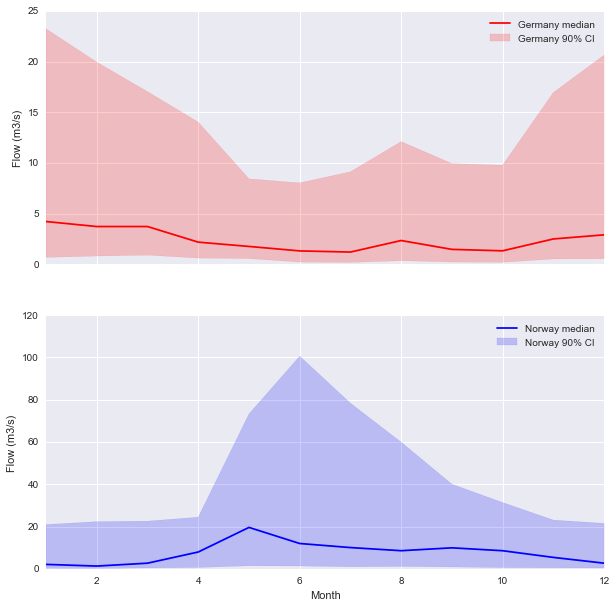

In [10]:
# Extract data of interest
hi_3yr_pb = hi_df.query('(eco_dataset=="pb") & (time_per==3)')
assert len(hi_3yr_pb) == 65

# Extract cols of interest
cols = ['country',] + ['avg%02d' % mon for mon in range(1, 13)]
mon_df = hi_3yr_pb[cols]
grpd = mon_df.groupby('country')
mon_df = grpd.describe(percentiles=[0.05, 0.50, 0.95])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, 
                         sharex=True, figsize=(10, 10))

# Germany
axes[0].fill_between(range(1, 13), 
                     mon_df.loc['D', '5%'].values,
                     mon_df.loc['D', '95%'].values,
                     color='r', alpha=0.2, 
                     label='Germany 90% CI')
axes[0].plot(range(1, 13), 
             mon_df.loc['D', '50%'].values,
             'r-', label='Germany median')

axes[0].set_ylabel('Flow (m3/s)')
axes[0].legend(loc='best')

# Norway
axes[1].fill_between(range(1, 13), 
                     mon_df.loc['N', '5%'].values,
                     mon_df.loc['N', '95%'].values,
                     color='b', alpha=0.2, 
                     label='Norway 90% CI')
axes[1].plot(range(1, 13), 
             mon_df.loc['N', '50%'].values,
             'b-', label='Norway median')

axes[1].set_ylabel('Flow (m3/s)')
axes[1].legend(loc='best')

plt.xlim((1, 12))
plt.xlabel('Month')

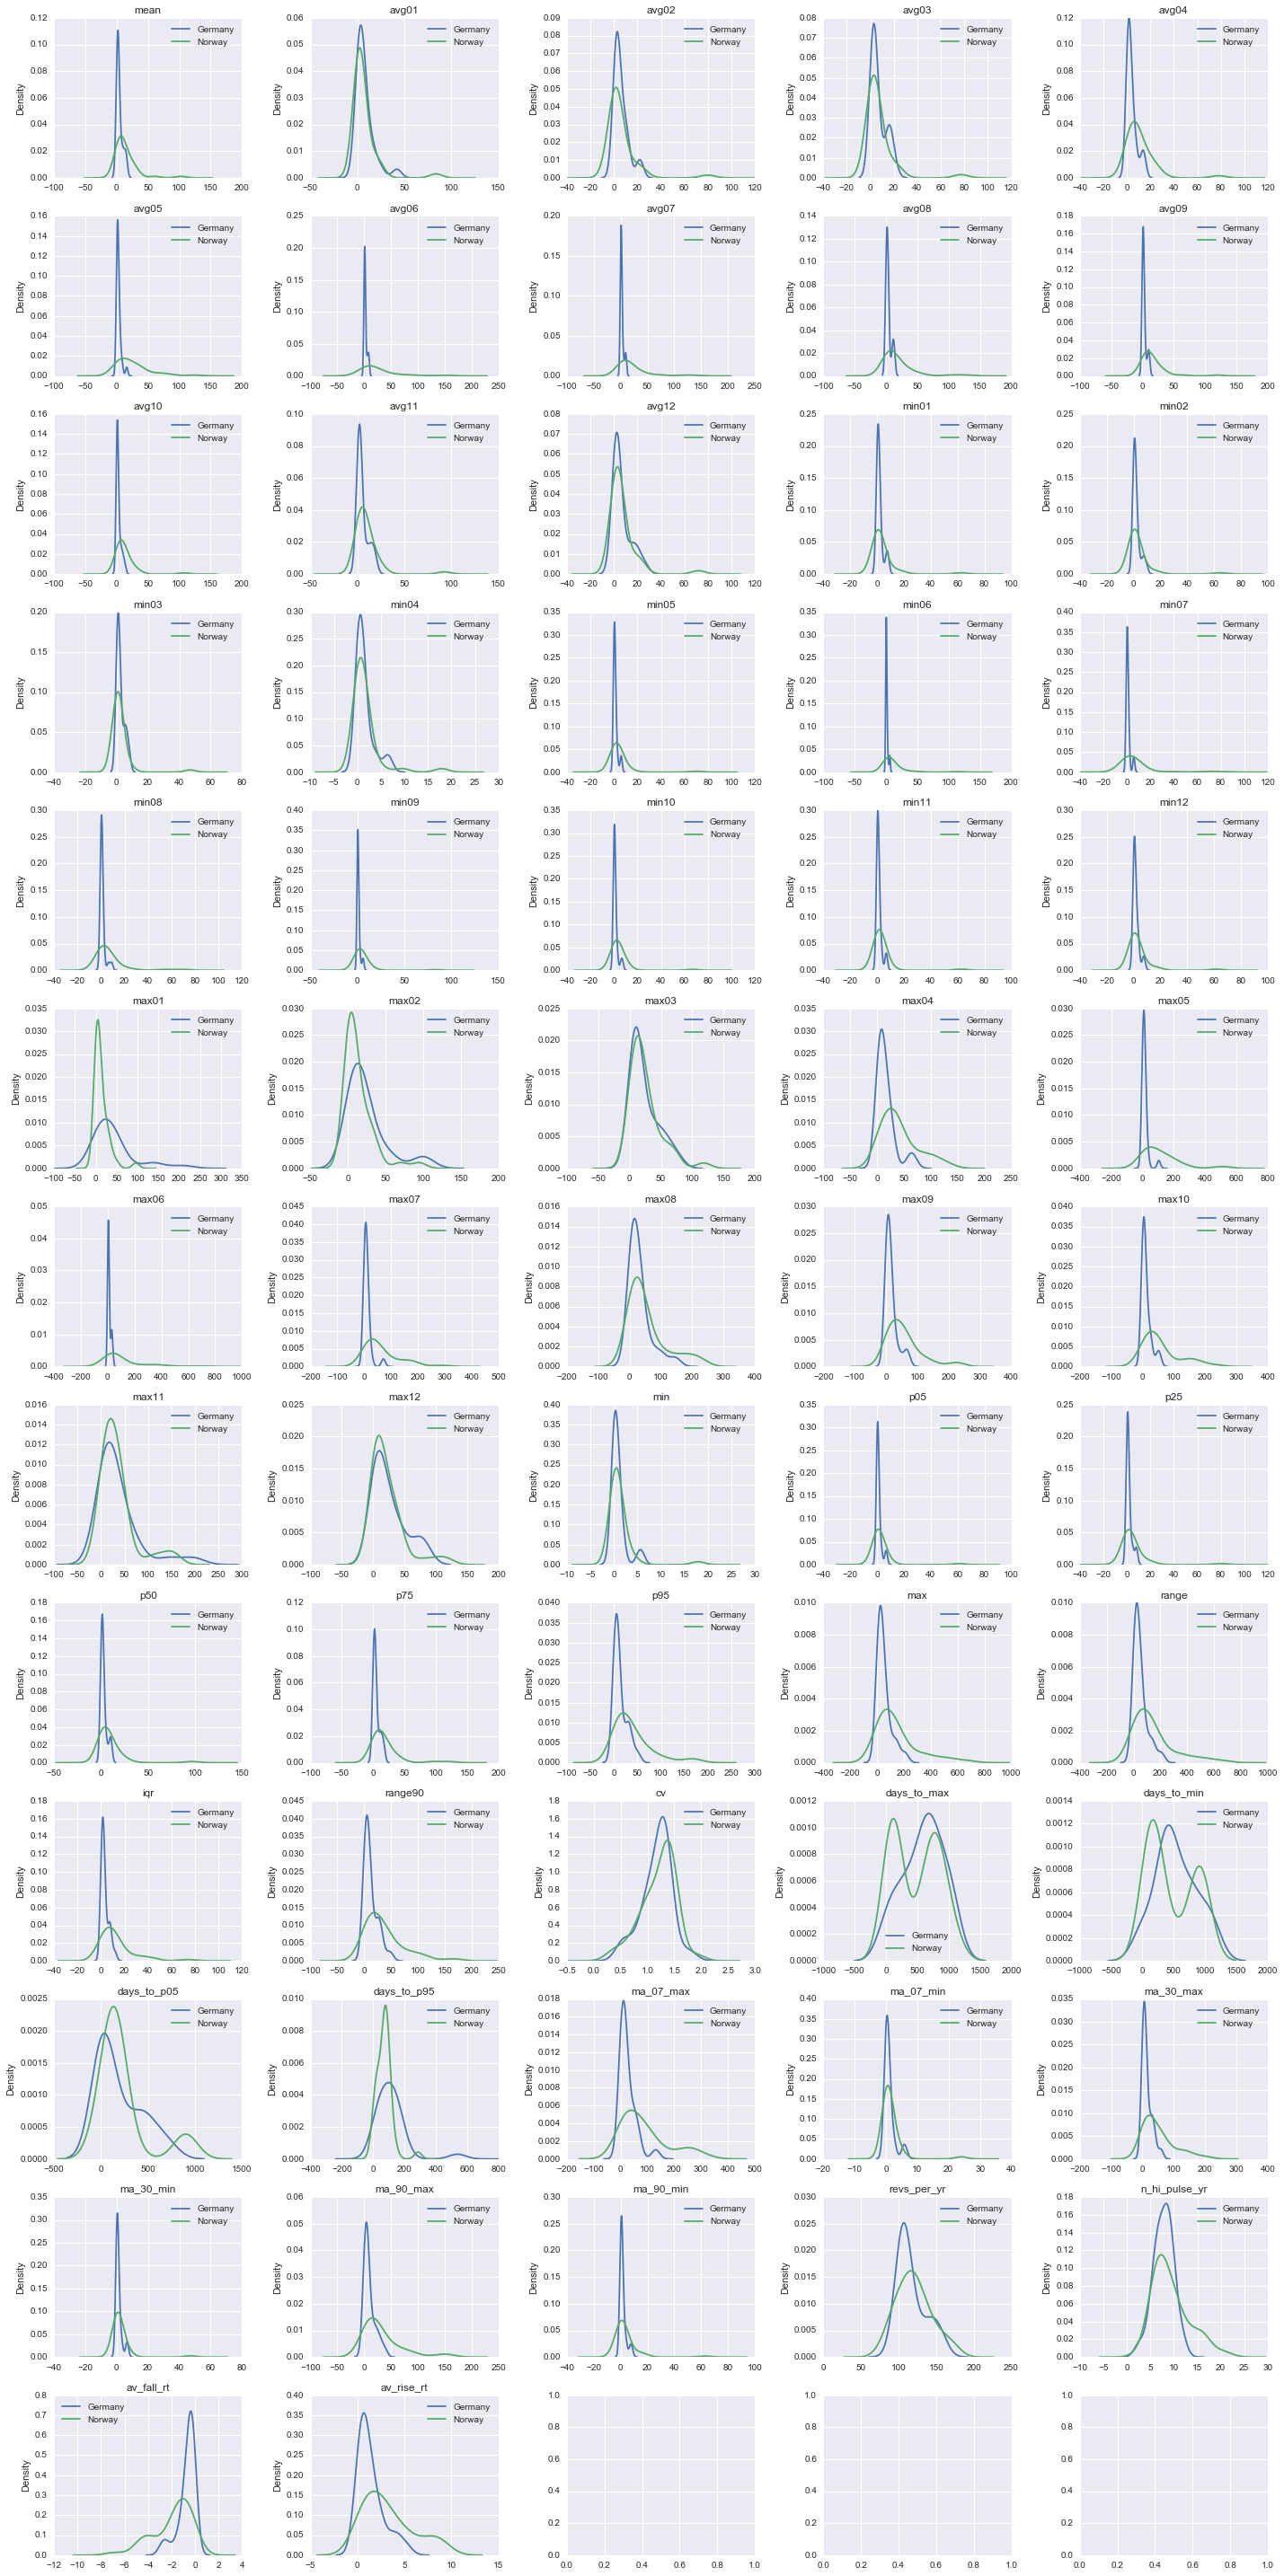

In [11]:
# Plot
fig, axes = plt.subplots(nrows=13, ncols=5, 
                         figsize=(20, 40))
ax = axes.flatten()

# Cols to exclude
excl_list = ['code', 'name', 'country', 'eco_dataset', 'time_per']

# Calc cols to include
cols = [col for col in hi_3yr_pb.columns if col not in excl_list]

# Loop over data
for idx, col in enumerate(cols):
    # Filter by country
    ger_data = hi_3yr_pb[['country', col]].query('country == "D"')
    nor_data = hi_3yr_pb[['country', col]].query('country == "N"')

    # KDE plots
    ger_data[col].plot.density(ax=ax[idx], label='Germany')
    nor_data[col].plot.density(ax=ax[idx], label='Norway')
    
    ax[idx].legend(loc='best')
    ax[idx].set_title(col)

plt.tight_layout()